## 1 Basic data

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import tensorly as ts
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
os.chdir("G:/jupyter/Guangzhou-data-set")
tensor = scipy.io.loadmat('tensor.mat')
tensor = tensor['tensor']
tensor = np.array(tensor)
print(tensor.shape)
tensor = tensor.reshape(214,-1)
print(tensor.shape)
tensor[tensor<=0]=(np.sum(tensor)*1.0/(tensor.shape[0]*tensor.shape[1]))
print((np.sum(tensor)*1.0/(tensor.shape[0]*tensor.shape[1])))


Using numpy backend.


(214, 61, 144)
(214, 8784)
39.000941942944365


In [2]:
tensor_1 = tensor[:,:8784-144*5]

missing_rate = 0.
condition = np.random.binomial(1, 1-missing_rate, np.shape(tensor_1)[0]*np.shape(tensor_1)[1])
condition = np.reshape(condition,(np.shape(tensor_1)[0],np.shape(tensor_1)[1]))
mask = np.where(condition<1,0.,1.)

print(mask.shape)
sparse_tensor1 = np.multiply(tensor_1, mask)

print(sparse_tensor1.shape)

mean = (np.sum(sparse_tensor1)*1.0/np.sum(mask))
init_tensor = sparse_tensor1
init_tensor[init_tensor==0] = mean
print(init_tensor.shape)

(214, 8064)
(214, 8064)
(214, 8064)


## 2  Raw speed sample

In [3]:
input_horizon = 6
pred_horizon = 1
network_size = 214
sampleset = []
field_predict_set=[]


    
for i in range(tensor_1.shape[1]-input_horizon-pred_horizon):
    sample = []
    field_predict = []
    for r in range(network_size):
        sample+=tensor_1[r,i:i+input_horizon].tolist()[:]
    for r in range(network_size):
        sample+=tensor_1[r,i+input_horizon:i+input_horizon+pred_horizon].tolist()[:]
        
    sampleset.append(sample)
    field_predict_set.append(tensor_1[:,i+input_horizon:i+input_horizon+pred_horizon].reshape(network_size))

print('Sample num: %d'%len(sampleset))

def generateBatch(samples,fieldset,epoch,input_horizon=input_horizon,feature_len=network_size,batchsize=32, istrain=True):
    xbatchset=[]
    ybatchset=[]
    lastspeedset=[]
    for i in range(batchsize):
        if istrain:
            index = epoch*batchsize+i
            xbatchset.append(samples[index+1][:input_horizon*feature_len])
            ybatchset.append(samples[index+1][input_horizon*feature_len:])
            lastspeedset.append(fieldset[index][-feature_len:][:])
            
    return xbatchset,ybatchset,lastspeedset

Sample num: 8057


## 3 Transformer model

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.02, shape=shape)
    return initial

class Model():
    def __init__(self,input_horizon, predict_horizon, networksize, feature_len):
        self.input_horizon = networksize
        self.predict_horizon = predict_horizon
        self.networksize = networksize
        self.feature_len = input_horizon
        self.bottom = tf.placeholder(tf.float32, shape=[None, self.input_horizon*self.feature_len], name='input')  
        self.target = tf.placeholder(tf.float32, shape=[None, self.predict_horizon*self.networksize], name='target')
        self.lastspeed = tf.placeholder(tf.float32, shape=[None, self.networksize], name='history')

        
    def build_TF(self,num_layers=1,batch_size=16,rnn_size=128): # rnn_size : output_size
        self.bottom1 = tf.reshape(self.bottom, [-1, self.feature_len])
        bottom = tf.reshape(self.bottom, [-1, self.feature_len])
        
        feat_dim=256
        
        W_q = weight_variable([self.feature_len, feat_dim])
        b_q = bias_variable([feat_dim])
        self.Q = tf.nn.elu(tf.matmul(bottom,W_q))+b_q
        self.Q = tf.reshape(self.Q,(-1,self.networksize,feat_dim))
        
        W_k = weight_variable([self.feature_len, feat_dim])
        b_k = bias_variable([feat_dim])
        self.K = tf.nn.elu(tf.matmul(bottom,W_k))+b_k
        self.K = tf.reshape(self.K,(-1,self.networksize,feat_dim))
        self.K = tf.transpose(self.K,(0,2,1))
                           
        W_v = weight_variable([self.feature_len, 1])
        b_v = bias_variable([1])
        self.V = tf.nn.elu(tf.matmul(bottom,W_v))+b_v
        self.V = tf.reshape(self.V,(-1,self.networksize,1))

    
        self.attention_ = tf.matmul(self.Q,self.K)/tf.sqrt(feat_dim*1.)        
        self.attention = tf.nn.softmax( self.attention_ )
        
        
        self.varaiation= tf.reshape(tf.matmul(self.attention,self.V),(-1,self.networksize*self.predict_horizon))#+self.lastspeed      
        
        self.predict = -self.varaiation+self.lastspeed
        
        self.loss_his = tf.reduce_mean(tf.squared_difference(self.target, self.lastspeed))
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.target, self.predict))
        self.accuracy = 1. - tf.reduce_mean(abs(self.target-self.predict)/self.target)
        self.learning_rate = 0.002
        
        self.trainop = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        
        

In [5]:
tf.reset_default_graph()
sess = tf.Session()

model = Model(input_horizon=input_horizon, predict_horizon=pred_horizon, networksize=network_size,feature_len=network_size)
model.build_TF()

# parameter initialization
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)
saver = tf.train.Saver()

In [7]:
end = 8748-144*5
trainset = sampleset[0:end]
train_field_predict_set = field_predict_set[0:end]

testset = sampleset[end:]
test_field_predict_set = field_predict_set[end:]

train_epochs = 18
batch_size = 144

for epoch in range(train_epochs):
    eploss = []
    train_field_loss = []
    for ep in range(int(len(trainset)/(batch_size+1))):
        x_batch, y_batch, lastspeed_batch = generateBatch(trainset,train_field_predict_set,batchsize=batch_size, epoch=ep)

        _, loss_, acc_train = sess.run([model.trainop, model.loss, model.accuracy],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch,model.lastspeed:lastspeed_batch})
        
        eploss.append(loss_)

        
    x_batch, y_batch,lastspeed_batch = generateBatch(testset, test_field_predict_set, batchsize=len(testset)-1, epoch=0)
    
    loss_, acc_train,loss_his = sess.run([model.loss, model.accuracy,model.loss_his ],
                                       feed_dict={model.bottom: x_batch, model.target: y_batch,model.lastspeed:lastspeed_batch})
    
    print('Epoch:%d==> Train loss: %g | Test field loss:%g |hisloss:%g'%(epoch,np.sqrt(float(sum(eploss)/len(eploss))),np.sqrt(loss_),np.sqrt(loss_his)))
    
save_path = saver.save(sess, "G:/jupyter/tmp2/model.ckpt")
    

Epoch:0==> Train loss: 3.01784 | Test field loss:2.50271 |hisloss:2.60859
Epoch:1==> Train loss: 3.01492 | Test field loss:2.50397 |hisloss:2.60859
Epoch:2==> Train loss: 3.01319 | Test field loss:2.50356 |hisloss:2.60859
Epoch:3==> Train loss: 3.01189 | Test field loss:2.50371 |hisloss:2.60859
Epoch:4==> Train loss: 3.01064 | Test field loss:2.50363 |hisloss:2.60859
Epoch:5==> Train loss: 3.00957 | Test field loss:2.50386 |hisloss:2.60859
Epoch:6==> Train loss: 3.00809 | Test field loss:2.50413 |hisloss:2.60859
Epoch:7==> Train loss: 3.0071 | Test field loss:2.50425 |hisloss:2.60859
Epoch:8==> Train loss: 3.006 | Test field loss:2.50647 |hisloss:2.60859
Epoch:9==> Train loss: 3.00429 | Test field loss:2.50602 |hisloss:2.60859
Epoch:10==> Train loss: 3.00462 | Test field loss:2.50485 |hisloss:2.60859
Epoch:11==> Train loss: 3.00236 | Test field loss:2.50388 |hisloss:2.60859
Epoch:12==> Train loss: 3.00211 | Test field loss:2.50451 |hisloss:2.60859
Epoch:13==> Train loss: 3.0007 | Test 

In [8]:
# definnition for validation
tensor_2 = tensor[:,-144*5:]
dim = tensor_2.shape

pred_result_set=[]
field_set = []
loss_set=[]
mf_loss_set=[]
hisresult=[]
variation_set=[]
for t in range(144*5-input_horizon):   
    tf.reset_default_graph()
    sess = tf.Session()
    model = Model(input_horizon=input_horizon, predict_horizon=pred_horizon, networksize=network_size,feature_len=network_size)
    model.build_TF()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if 1:
        saver.restore(sess, "G:/jupyter/tmp2/model.ckpt")
    input_tensor = tensor_2[:,t:t+input_horizon]
    condition = np.random.binomial(1, 1-missing_rate, np.shape(input_tensor)[0]*np.shape(input_tensor)[1])
    condition = np.reshape(condition,(np.shape(input_tensor)[0],np.shape(input_tensor)[1]))
    mask2 = np.where(condition<1,0.,1.)
    sparse_tensor2 = np.multiply(input_tensor, mask2)
    
    tensor_holder_valid = tf.placeholder(tf.float32, shape=[input_tensor.shape[0],input_tensor.shape[1]]) 
    mask_tensor_holder_valid =  tf.placeholder(tf.float32, shape=[input_tensor.shape[0],input_tensor.shape[1]])
#     init_tensor = sparse_tensor
#     init_tensor[init_tensor==0] = mean
    
    # input feature production
#     X = tf.Variable(tf.truncated_normal([rank1,input_tensor.shape[1]], stddev=0.05))

#     Train_Param_valid=[X]
#     impute_tensor_valid = tf.matmul(W_base, X)
#     loss_valid = tf.reduce_mean((mask_tensor_holder_valid * tensor_holder_valid - mask_tensor_holder_valid * impute_tensor_valid) ** 2)
#     loss_evaluation = tf.reduce_sum(((1.-mask_tensor_holder_valid)*tensor_holder_valid - (1.-mask_tensor_holder_valid) * impute_tensor_valid)  ** 2) / (tf.math.reduce_sum(1.-mask_tensor_holder_valid))
#     loss_all = tf.reduce_mean((tensor_holder_valid - impute_tensor_valid) ** 2)
#     solver_valid = tf.train.AdamOptimizer(0.008).minimize(loss_valid, var_list=Train_Param_valid)

#     # parameter initialization
#     sess2 = tf.Session()
#     init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
#     sess2.run(init_op)
#     temp=[]
#     X_predict_target_validate_temp = np.zeros([rank1,input_tensor.shape[1]])
    
#     loss_valid_ = 1000
#     i = 0
#     while loss_valid_>3: 
#         _, loss_valid_, it, X_predict_target_validate,loss_all_ = sess2.run([solver_valid, loss_valid, impute_tensor_valid, X,loss_all], feed_dict={mask_tensor_holder_valid:mask2, tensor_holder_valid:input_tensor})
#         temp.append(sum(sum(abs(X_predict_target_validate-X_predict_target_validate_temp))))
#         X_predict_target_validate_temp = X_predict_target_validate
#         i+=1
#         if i>500:
#             break
#     print('TRAIN RMSE = {:.6}'.format(np.sqrt(loss_valid_)))
#     print('Overall Recover RMSE = {:.6}'.format(np.sqrt(loss_all_)))

    # feature prediction & speed prediction
    field=tensor_2[:,t+input_horizon]
    field = np.array(field).reshape(-1,network_size*pred_horizon)
    
    field_loss_,pred_result,lastspeed,variation = sess.run([model.loss, model.predict,model.lastspeed,model.varaiation],feed_dict={model.bottom:tensor_2[:,t:t+input_horizon].reshape(1,-1),model.lastspeed:tensor_2[:,t+input_horizon-1].reshape(1,-1),model.target:field.reshape(1,-1)})

    print('##Epoch %d field loss %g'%(t, np.sqrt(field_loss_)))
    print('-------------------------------------------------')
    pred_result_set.append(pred_result[0])
    hisresult.append(lastspeed[0])
    field_set.append(field[0])
    loss_set.append(np.sqrt(field_loss_))
    variation_set.append(variation[0])
#     mf_loss_set.append(np.sqrt(loss_valid_))

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 0 field loss 1.75339
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 1 field loss 2.04161
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 2 field loss 1.90879
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 3 field loss 2.06157
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 4 field loss 2.03655
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 5 field loss 2.05987
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 6 field loss 2.60489
--------------

##Epoch 55 field loss 3.88315
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 56 field loss 3.35648
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 57 field loss 3.50752
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 58 field loss 3.61374
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 59 field loss 3.11988
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 60 field loss 3.52648
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 61 field loss 3.45504
-------------------------------------------------
INFO:tensorflow:Restoring 

##Epoch 110 field loss 3.59455
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 111 field loss 3.82895
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 112 field loss 3.95362
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 113 field loss 3.44185
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 114 field loss 2.99234
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 115 field loss 2.53147
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 116 field loss 2.17931
-------------------------------------------------
INFO:tensorflow:Res

##Epoch 165 field loss 3.14472
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 166 field loss 2.89983
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 167 field loss 14.7816
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 168 field loss 14.828
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 169 field loss 3.35988
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 170 field loss 3.18121
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 171 field loss 3.56851
-------------------------------------------------
INFO:tensorflow:Rest

##Epoch 220 field loss 3.59803
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 221 field loss 3.29172
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 222 field loss 3.31626
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 223 field loss 4.11544
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 224 field loss 2.95663
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 225 field loss 2.96107
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 226 field loss 4.00777
-------------------------------------------------
INFO:tensorflow:Res

##Epoch 275 field loss 1.96786
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 276 field loss 1.95069
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 277 field loss 1.55733
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 278 field loss 2.00046
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 279 field loss 1.88623
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 280 field loss 2.01383
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 281 field loss 1.89746
-------------------------------------------------
INFO:tensorflow:Res

##Epoch 330 field loss 3.40243
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 331 field loss 3.42853
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 332 field loss 3.34015
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 333 field loss 3.96689
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 334 field loss 3.33114
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 335 field loss 3.34039
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 336 field loss 3.8907
-------------------------------------------------
INFO:tensorflow:Rest

##Epoch 385 field loss 4.10093
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 386 field loss 3.89586
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 387 field loss 3.49527
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 388 field loss 4.25576
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 389 field loss 3.55418
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 390 field loss 3.54522
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 391 field loss 3.68176
-------------------------------------------------
INFO:tensorflow:Res

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 440 field loss 2.30877
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 441 field loss 2.29931
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 442 field loss 2.2014
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 443 field loss 2.09673
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 444 field loss 2.22529
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 445 field loss 2.26381
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 446 field loss 2.44885
-

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 495 field loss 3.05069
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 496 field loss 2.95048
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 497 field loss 3.17413
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 498 field loss 3.07714
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 499 field loss 3.00636
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 500 field loss 3.61557
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 501 field loss 2.8304
-

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 550 field loss 3.009
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 551 field loss 3.2881
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 552 field loss 2.86649
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 553 field loss 2.65308
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 554 field loss 2.80366
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 555 field loss 2.88627
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 556 field loss 3.08811
---

INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 605 field loss 2.77516
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 606 field loss 3.63291
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 607 field loss 2.80952
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 608 field loss 3.33833
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 609 field loss 2.86129
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 610 field loss 2.89709
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 611 field loss 3.47202


INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 660 field loss 3.73639
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 661 field loss 3.53269
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 662 field loss 3.72683
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 663 field loss 3.09234
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 664 field loss 3.11129
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 665 field loss 3.88737
-------------------------------------------------
INFO:tensorflow:Restoring parameters from G:/jupyter/tmp2/model.ckpt
##Epoch 666 field loss 3.63003


3.2844118927731354


<function matplotlib.pyplot.show(*args, **kw)>

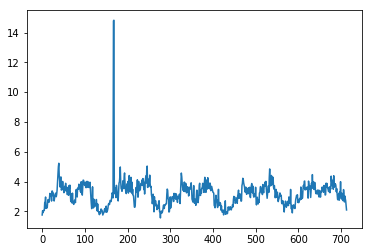

In [9]:
variation_set = np.array(variation_set)
pred_result_set = np.array(pred_result_set)
field_set = np.array(field_set)
final_rmse = np.sqrt(np.sum((pred_result_set - field_set) ** 2)/field_set.shape[0]/field_set.shape[1])
print(final_rmse)

plt.plot(loss_set)
# plt.plot(mf_loss_set)
plt.show

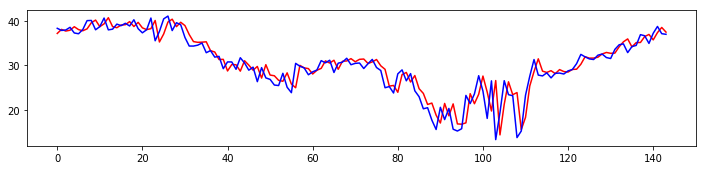

In [10]:
plt.figure(figsize = (12, 2.5))
road =168
plt.plot(pred_result_set[144:288,road], 'r', field_set[144:288,road], 'b')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

3.409478391840812


<function matplotlib.pyplot.show(*args, **kw)>

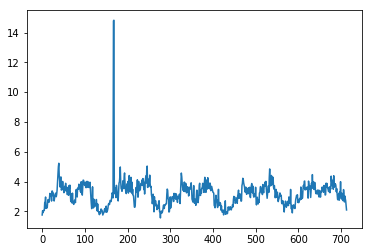

In [11]:
variation_set = np.array(variation_set)
hisresult = np.array(hisresult)
field_set = np.array(field_set)
final_rmse = np.sqrt(np.sum((hisresult - field_set) ** 2)/field_set.shape[0]/field_set.shape[1])
print(final_rmse)

plt.plot(loss_set)
# plt.plot(mf_loss_set)
plt.show

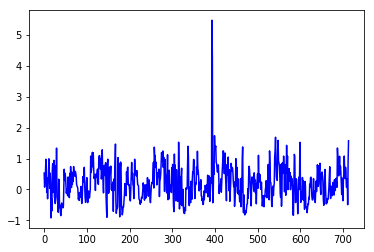

In [12]:
# plt.plot(variation_set[:,road], 'r')
road=89
v=[pred_result_set[i,road]-hisresult[i,road] for i in range(len(pred_result_set))]
plt.plot(v, 'b')
plt.show()

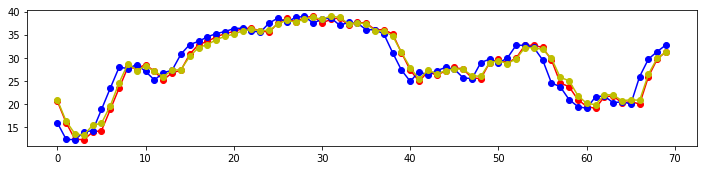

In [13]:
hisresult = np.array(hisresult)
plt.figure(figsize = (12, 2.5))
road = 17
plt.plot(hisresult[330:400,road], 'r-o', field_set[330:400,road], 'b-o',pred_result_set[330:400,road], 'y-o')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

3.409478391840812


<function matplotlib.pyplot.show(*args, **kw)>

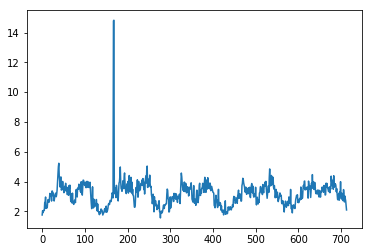

In [14]:
hisresult = np.array(hisresult) 
field_set = np.array(field_set) 
final_rmse = np.sqrt(np.sum((hisresult - field_set) ** 2)/field_set.shape[0]/field.shape[1])
print(final_rmse)

plt.plot(loss_set)
# plt.plot(mf_loss_set)
plt.show

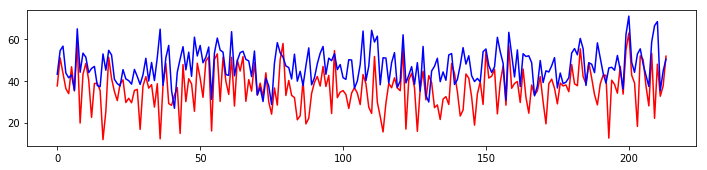

In [15]:
plt.figure(figsize = (12, 2.5))
road = 8
plt.plot(pred_result_set[168,:], 'r', field_set[168,:], 'b')
# plt.plot(pred_result_set[road, :]/field[road, :], 'b')
plt.show()

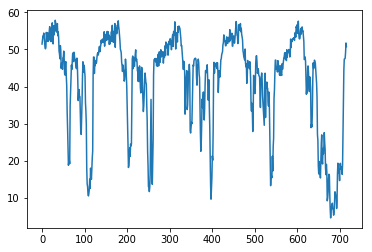

In [25]:
plt.plot(field_set[:,1])

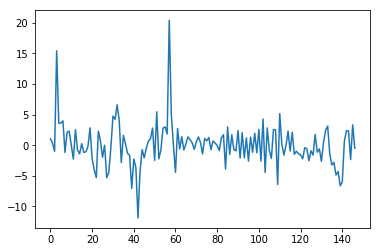

In [101]:
v=[]
road=1
i=66
while i+1<(tensor_2.shape[0]):
    v.append(tensor_2[road,i+1]-tensor_2[road,i])
    i+=1
plt.plot(v)

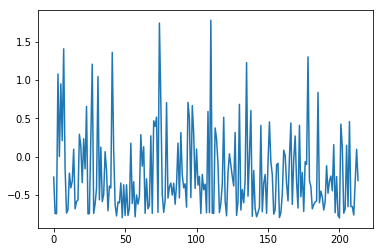

In [17]:
plt.plot(variation_set[9,:])